In [270]:
## sostituire questa cartella con folder locale. la cartella può essere scaricata da qui:
# https://github.com/gabrielepinto/dati_simulatore_elettorale/dati_app
folder_head="D:\\database_vari_miei\\simulatore\\dati_app\\"

# importa moduli necessari
# N.B. controllare che il file funzionisimulatore.py si trovi nella cartella. il modulo può essere scaricato da qui:
# https://github.com/gabrielepinto/dati_simulatore_elettorale/
from funzionisimulatore import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## importa dati

In [36]:
### importa dati scenario di base e nomi collegi
camera_match=pd.read_csv(folder_head+"pluri_uni_camera.csv",encoding="windows-1252",sep=";")
senato_match=pd.read_csv(folder_head+"pluri_uni_senato.csv",encoding="windows-1252",sep=";")


camera=pd.read_csv(folder_head+"camera_bilanciato.csv",encoding="windows-1252",sep=";")
senato=pd.read_csv(folder_head+"senato_bilanciato.csv",encoding="windows-1252",sep=";")
seggi_senato=pd.read_excel(folder_head+"seggi_senato.xlsx")
seggi_camera=pd.read_excel(folder_head+"seggi_camera.xlsx")
seggi_camera_plurinominale=pd.read_excel(folder_head+"seggi_camera_plurinominale.xlsx")
seggi_senato_plurinominale=pd.read_excel(folder_head+"seggi_senato_plurinominale.xlsx")


### aggiorna alle ultime stime dei sondaggi

stime=pd.read_excel(folder_head+"stime_partiti.xlsx",sheet_name="STIME")
for z in range(0,20):    
    for i,party in stime.iterrows():
        aumento_voti_partito(camera,partito=party.party,increase=party.stima)
## for tuning
for z in range(0,20):    
    for i,party in stime.iterrows():
        aumento_voti_partito(senato,partito=party.party,increase=party.stima)

dr=pd.read_excel(folder_head+"stime_partiti.xlsx",sheet_name="COALIZIONI")
lista_coalizione=dr.columns[1:]
diz_coalizione=dict(zip(dr["LISTA"],dr[lista_coalizione[0]]))

#### percentuali scenario di base

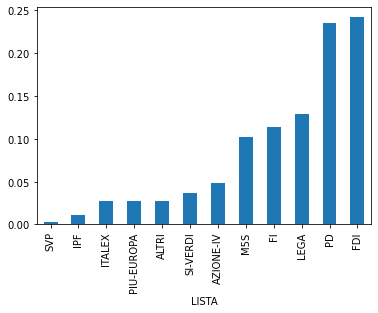

In [37]:
## percentuali scenario di base
(camera.groupby("LISTA")["VOTI_LISTA"].sum()/camera["VOTI_LISTA"].sum()).sort_values().plot(kind="bar");

## Camera dei deputati e Senato

carica la lista dei candidati in tutti i collegi

In [248]:
cand_plur=pd.read_excel(folder_head+"liste_candidati.xlsx",sheet_name="plurinominale_camera")
cand_uni=pd.read_excel(folder_head+"liste_candidati.xlsx",sheet_name="uninominale_camera")

cand_plur_senato=pd.read_excel(folder_head+"liste_candidati.xlsx",sheet_name="plurinominale_senato")
cand_uni_senato=pd.read_excel(folder_head+"liste_candidati.xlsx",sheet_name="uninominale_senato")

correzione per candidati Democratici e Progressisti non definiti (da cancellare con liste definitive)

In [249]:
cand_uni.loc[cand_uni["CANDIDATO"].str.contains("Coalizione"),"CANDIDATO"]=cand_uni.loc[cand_uni["CANDIDATO"].str.contains("Coalizione"),"COLLEGIOUNINOMINALE"]+"-COALIZIONE"
cand_uni_senato.loc[cand_uni_senato["CANDIDATO"].str.contains("Coalizione"),"CANDIDATO"]=cand_uni_senato.loc[cand_uni_senato["CANDIDATO"].str.contains("Coalizione"),"COLLEGIOUNINOMINALE"]+"-COALIZIONE"

funzione per vedere chi sono gli eletti alla camera

In [250]:
### funzione per vedere chi sono gli eletti 
def eletti_plurinom_camera(alloc_seggi,partito="PD"):    
    ### prendi l'allocazione dei seggi per tutti i partiti
    eletti=pd.DataFrame()
    ### for row in allocazione_seggi...
    for i,row in alloc_seggi.iterrows():
        ### filtra gli eletti
        # in quel collegio
        # di quel partito
        # entro le posizioni assegnate
        elect_to_append=cand_plur.loc[(cand_plur["COLLEGIOPLURINOMINALE"]==row["COLLEGIOPLURINOMINALE"])&
                                      (cand_plur["PARTITO"]==partito)&
                                      (cand_plur["POSIZIONE"]<=row[partito])].copy()

        eletti=eletti.append(elect_to_append)
    return eletti

funzione per vedere chi sono gli eletti al senato

In [251]:
### funzione per vedere chi sono gli eletti 
def eletti_plurinom_senato(alloc_seggi,partito="PD"):    
    ### prendi l'allocazione dei seggi per tutti i partiti
    eletti=pd.DataFrame()
    ### for row in allocazione_seggi...
    for i,row in alloc_seggi.iterrows():
        ### filtra gli eletti
        # in quel collegio
        # di quel partito
        # entro le posizioni assegnate
        elect_to_append=cand_plur_senato.loc[(cand_plur_senato["COLLEGIOPLURINOMINALE"]==row["COLLEGIOPLURINOMINALE"])&
                                      (cand_plur_senato["PARTITO"]==partito)&
                                      (cand_plur_senato["POSIZIONE"]<=row[partito])].copy()

        eletti=eletti.append(elect_to_append)
    return eletti

funzione per calcolare i risultati degli scenari alla camera

In [252]:
def calcola_risultati_scenario_camera(camera,partito="PD"):
    #DECRETO DEL PRESIDENTE DELLA REPUBBLICA 30 marzo 1957, n. 361 art.85
    ## calcola percentuale nei collegi plurinominali
    all_results_camera=pd.merge(camera,camera_match,on="COLLEGIOUNINOMINALE")
    ## compute percentage of voti lista over votanti by lista in collegioplurinominale
    seggi_plurinom=all_results_camera.groupby(["COLLEGIOPLURINOMINALE","LISTA"],as_index=False)["VOTI_LISTA"].sum().pivot(index="COLLEGIOPLURINOMINALE",columns="LISTA",values="VOTI_LISTA")
    ### percentuali nei collegi
    perc_collegi=seggi_plurinom.div(seggi_plurinom.sum(axis=1),axis=0)

    ### calcola numero di seggi allocati per collegio
    allocazione_seggi=allocazione_plurinom_camera(camera=camera,diz=diz_coalizione,seggi_camera=seggi_camera)
    ### questo serve per levare collegio plurinominale dall'indice
    allocazione_seggi.reset_index(inplace=True)
    ### quanti sono in tutto
    if partito in allocazione_seggi.columns:
        num_da_eleggere=allocazione_seggi[partito].sum().copy()
        #### chi sono
        eletti=eletti_plurinom_camera(alloc_seggi=allocazione_seggi,partito=partito)
        ## trova candidati eletti in piu collegi 
        candidati_multipli=eletti["CANDIDATO"].value_counts()[eletti["CANDIDATO"].value_counts()>1].index
        ## dataframe con candidati multipli
        da_verificare=eletti.loc[eletti["CANDIDATO"].isin(candidati_multipli)]
        ## unisci ai risultati percentuali di collegio
        da_verificare=pd.merge(da_verificare,perc_collegi[partito].reset_index())

        '''
        ((1. Il deputato eletto in piu' collegi plurinominali e' proclamato
        nel collegio nel quale la lista cui appartiene ha ottenuto la  minore
        cifra elettorale percentuale di collegio  plurinominale,  determinata
        ai sensi dell'articolo 77, comma 1, lettera e) )). 
        '''
        ## verifica dove è la percentuale minima per ogni candidato (dove verrà eletto)
        da_verificare["minimo"]=da_verificare.groupby(["CANDIDATO"])[partito].transform("min")
        ## prendi i collegi dove si è liberata una posizione
        da_verificare["replace"]=da_verificare[partito]!=da_verificare["minimo"]

        '''
         ((1-bis. Il deputato eletto in un collegio uninominale e in  uno  o
        piu'  collegi  plurinominali   si   intende   eletto   nel   collegio
        uninominale)). 
        '''
        ### qui ci va una funzione per trovare i nomi degli eletti nell'uninominale

        result_uninom=tabella_uninom(camera,diz=diz_coalizione).reset_index(drop=False)
        collegi_vinti=result_uninom.loc[result_uninom["VINCITORE"].str.contains(partito),"COLLEGIOUNINOMINALE"]
        eletti_uninominale=cand_uni.loc[(cand_uni["PARTITO"]==partito)&(cand_uni["COLLEGIOUNINOMINALE"].isin(collegi_vinti)),"CANDIDATO"].unique()
        ### li aggiungo a quelli che vanno rimpiazzati
        da_verificare.loc[da_verificare["CANDIDATO"].isin(eletti_uninominale),"replace"]=True

        ## prendi dataset con collegi e posizioni da incrementare ovvero dove replace =TRUE
        incrementi=da_verificare.loc[da_verificare["replace"],"COLLEGIOPLURINOMINALE"].value_counts()
        ## incrementa le posizioni
        for collegio,incremento in incrementi.iteritems():
             allocazione_seggi.loc[allocazione_seggi["COLLEGIOPLURINOMINALE"]==collegio,partito]+=incremento

        ## adesso rifai gli eletti
        eletti=eletti_plurinom_camera(alloc_seggi=allocazione_seggi,partito=partito)
        num_cand_unici=eletti["CANDIDATO"].nunique()
        eletti_finali_plurinominali=set(eletti["CANDIDATO"].unique())
        eletti_finali=list(set(eletti_finali_plurinominali).union(set(eletti_uninominale)))
    else:
        eletti_finali=[]
    return eletti_finali

funzione per vedere i risultati dello scenario al senato

In [253]:
def calcola_risultati_scenario_senato(senato,partito="PD"):

    ## calcola percentuale nei collegi plurinominali
    all_results_camera=pd.merge(senato,senato_match,on="COLLEGIOUNINOMINALE")
    ## compute percentage of voti lista over votanti by lista in collegioplurinominale
    seggi_plurinom=all_results_camera.groupby(["COLLEGIOPLURINOMINALE","LISTA"],as_index=False)["VOTI_LISTA"].sum().pivot(index="COLLEGIOPLURINOMINALE",columns="LISTA",values="VOTI_LISTA")
    ### percentuali nei collegi
    perc_collegi=seggi_plurinom.div(seggi_plurinom.sum(axis=1),axis=0)

    ### calcola numero di seggi allocati per collegio
    allocazione_seggi=allocazione_plurinom_senato(senato,diz=diz_coalizione,seggi_senato=seggi_senato)
    ### questo serve per levare collegio plurinominale dall'indice
    allocazione_seggi.reset_index(inplace=True)
    ### quanti sono in tutto
    if partito in allocazione_seggi.columns:
        num_da_eleggere=allocazione_seggi[partito].sum().copy()
        #### chi sono
        eletti=eletti_plurinom_senato(alloc_seggi=allocazione_seggi,partito=partito)


        ## trova candidati eletti in piu collegi 
        candidati_multipli=eletti["CANDIDATO"].value_counts()[eletti["CANDIDATO"].value_counts()>1].index
        ## dataframe con candidati multipli
        da_verificare=eletti.loc[eletti["CANDIDATO"].isin(candidati_multipli)]
        ## unisci ai risultati percentuali di collegio
        da_verificare=pd.merge(da_verificare,perc_collegi[partito].reset_index())

        '''
        ((1. Il deputato eletto in piu' collegi plurinominali e' proclamato
        nel collegio nel quale la lista cui appartiene ha ottenuto la  minore
        cifra elettorale percentuale di collegio  plurinominale,  determinata
        ai sensi dell'articolo 77, comma 1, lettera e) )). 
        '''
        ## verifica dove è la percentuale minima per ogni candidato (dove verrà eletto)
        da_verificare["minimo"]=da_verificare.groupby(["CANDIDATO"])[partito].transform("min")
        ## prendi i collegi dove si è liberata una posizione
        da_verificare["replace"]=da_verificare[partito]!=da_verificare["minimo"]

        '''
         ((1-bis. Il deputato eletto in un collegio uninominale e in  uno  o
        piu'  collegi  plurinominali   si   intende   eletto   nel   collegio
        uninominale)). 
        '''
        ### qui ci va una funzione per trovare i nomi degli eletti nell'uninominale

        result_uninom=tabella_uninom(camera,diz=diz_coalizione).reset_index(drop=False)
        collegi_vinti=result_uninom.loc[result_uninom["VINCITORE"].str.contains(partito),"COLLEGIOUNINOMINALE"]
        eletti_uninominale=cand_uni_senato.loc[(cand_uni_senato["PARTITO"]==partito)&(cand_uni_senato["COLLEGIOUNINOMINALE"].isin(collegi_vinti)),"CANDIDATO"].unique()
        ### li aggiungo a quelli che vanno rimpiazzati
        da_verificare.loc[da_verificare["CANDIDATO"].isin(eletti_uninominale),"replace"]=True

        ## prendi dataset con collegi e posizioni da incrementare ovvero dove replace =TRUE
        incrementi=da_verificare.loc[da_verificare["replace"],"COLLEGIOPLURINOMINALE"].value_counts()
        ## incrementa le posizioni
        for collegio,incremento in incrementi.iteritems():
             allocazione_seggi.loc[allocazione_seggi["COLLEGIOPLURINOMINALE"]==collegio,partito]+=incremento

        ## adesso rifai gli eletti
        eletti=eletti_plurinom_senato(alloc_seggi=allocazione_seggi,partito=partito)
        num_cand_unici=eletti["CANDIDATO"].nunique()
        eletti_finali_plurinominali=set(eletti["CANDIDATO"].unique())
        eletti_finali=list(set(eletti_finali_plurinominali).union(set(eletti_uninominale)))
    else:
        eletti_finali=[]
    return eletti_finali

## definizione scenari

In [254]:
## aumenti rispetto allo scenario di base
aumenti=[0.25,0.5,0.75,0.85,1,1.15,1.25,1.5,1.75]
### probabilità di accadimento in ogni scenario
probabilita=[0.02,0.03,0.1,0.2,0.3,0.2,0.1,0.03,0.02]

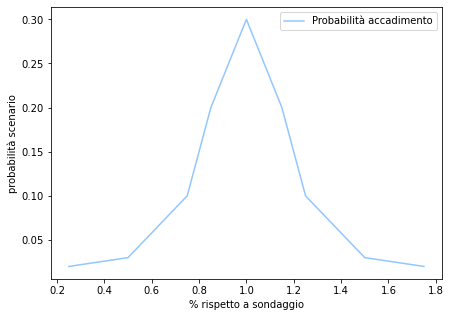

In [255]:
## distribuzione della probabilità degli scenari
fig,axs=plt.subplots(figsize=(7,5))
pd.DataFrame({"% rispetto a sondaggio":aumenti,"Probabilità accadimento":probabilita}).plot(
    kind="line",y="Probabilità accadimento",x="% rispetto a sondaggio",ax=axs)
axs.set_ylabel("probabilità scenario");

ad esempio per il PD (figura in basso linea rossa), ipotizziamo diversi scenari che vanno dal 5% al 40% su base nazionale.
Mentre per la lega (figura in basso linea blu), ipotizziamo diversi scenari che vanno 3% al 22%....Notare che gli scenari estremi (es:Lega che prende il 3% o PD che prende il 5%) hanno delle probabilità di acccadimento molto basse (2%),

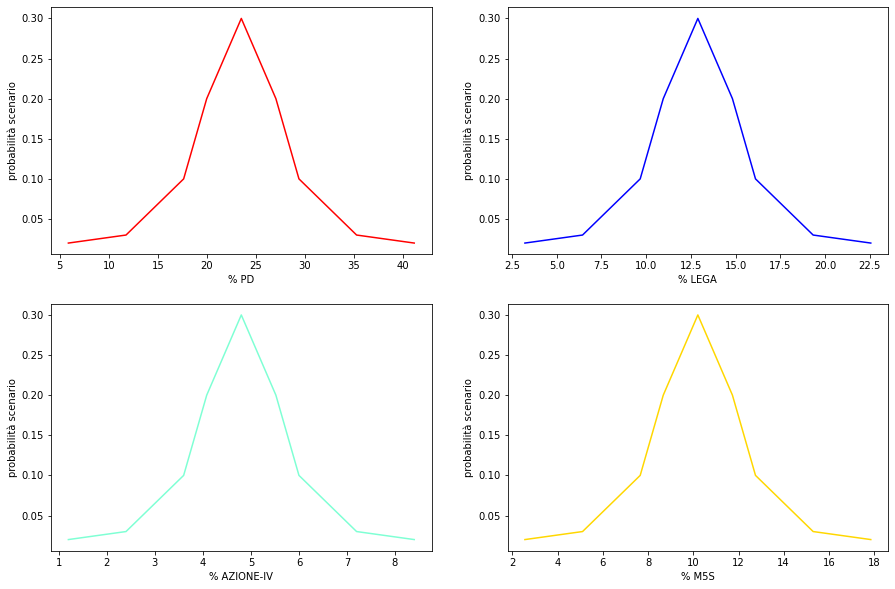

In [256]:
d_plot=pd.DataFrame({"% rispetto a sondaggio":aumenti,"Probabilità accadimento":probabilita})
for party in ["PD","LEGA","AZIONE-IV","M5S"]:    
    d_plot["% {0}".format(party)]=d_plot["% rispetto a sondaggio"]*cp(party,mean=1)*100

fig,axss=plt.subplots(ncols=2,nrows=2,figsize=(15,10))
axs=axss.flatten()

for i,party,colorz in  zip(range(0,len(axs)),["PD","LEGA","AZIONE-IV","M5S"],["red","blue","aquamarine","gold"]):    
    d_plot.plot(
        kind="line",y="Probabilità accadimento",x="% {0}".format(party),ax=axs[i],color=colorz,legend=False)
    axs[i].set_ylabel("probabilità scenario");


## Ora facciamo le simulazioni....

questa cella ci può mettere anche 10 minuti a partito...

In [259]:
%%time

eletti_camera_all=pd.DataFrame()
eletti_senato_all=pd.DataFrame()

### per il partito
for partito in ["AZIONE-IV","PD","M5S"]:
    ## per ogni aumento di ogni scenario
    for aumento in aumenti:
        ### calcola la media del partito
        media_partito=cp(partito,mean=1)

        #### aumentare la media del partito dello scenario di base per l'aumento
        aumento_voti_partito(camera,increase=media_partito*aumento,partito=partito)
        aumento_voti_partito(senato,increase=media_partito*aumento,partito=partito)
        ### calcola i risultati dello scenari
        eletti_camera=calcola_risultati_scenario_camera(camera=camera,partito=partito)
        eletti_senato=calcola_risultati_scenario_senato(senato,partito=partito)

        ### salvali in un dataframe
        eletti_camera_all=eletti_camera_all.append(pd.DataFrame({"candidato":eletti_camera,"scenario":aumento,"partito":partito}))
        eletti_senato_all=eletti_senato_all.append(pd.DataFrame({"candidato":eletti_senato,"scenario":aumento,"partito":partito}))
        ### ricalibra i dataset riportandoli allo scenario di base
        for z in range(0,20):    
            for i,party in stime.iterrows():
                aumento_voti_partito(camera,partito=party.party,increase=party.stima)
        ## for tuning
        for z in range(0,20):    
            for i,party in stime.iterrows():
                aumento_voti_partito(senato,partito=party.party,increase=party.stima)

Wall time: 14min 16s


lega le probabilità di ogni scenario agli aumenti...

In [260]:
eletti_camera_all["probabilità di elezione"]=eletti_camera_all["scenario"].replace(dict(zip(aumenti,probabilita)))
eletti_senato_all["probabilità di elezione"]=eletti_senato_all["scenario"].replace(dict(zip(aumenti,probabilita)))

ora calcolà la probabilità totale sommandola su tutti gli scenari.


In [261]:
risultati_finali=eletti_camera_all.groupby(["candidato","partito"],as_index=False)["probabilità di elezione"].sum()

risultati_finali_senato=eletti_senato_all.groupby(["candidato","partito"],as_index=False)["probabilità di elezione"].sum()


## come si distribuisce la probabilità ?

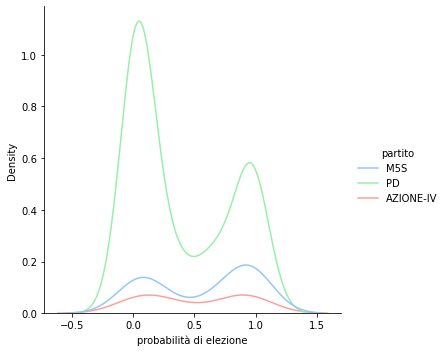

In [263]:
sns.displot(risultati_finali,x="probabilità di elezione",hue="partito",kind="kde");

In [264]:
### mostra i primi e gli ultimi
risultati_finali.sort_values("probabilità di elezione",ascending=False).head(10)

,candidato,partito,probabilità di elezione
153,Luciano D'Alfonso,PD,1.0
14,Andrea Gnassi,PD,1.0
112,Gian Antonio Girelli,PD,1.0
80,Elly Schlein,PD,1.0
22,Anthony Barbagallo,PD,1.0
210,Piero De Luca,PD,1.0
20,Anna Ascani,PD,1.0
73,Debora Serracchiani,PD,1.0
178,Matteo Orfini,PD,1.0
149,Lorenzo Guerini,PD,1.0


In [265]:
risultati_finali_senato.sort_values("probabilità di elezione",ascending=False).head(10)

,candidato,partito,probabilità di elezione
21,Beatrice Lorenzin,PD,1.00
95,Sandra Zampa,PD,1.00
41,Dario Parrini,PD,1.00
40,Dario Franceschini,PD,1.00
51,Francesco Boccia,PD,1.00
32,Cecilia D'Elia,PD,1.00
26,Carlo Cottarelli,PD,1.00
46,Enrico Borghi,PD,1.00
102,Tatiana Rojc,PD,1.00
28,Castellone Mariolina,M5S,0.98


in media qual'è la probabilità di essere eletti per una data posizione in lista?

In [266]:
check=pd.merge(risultati_finali,
        cand_plur.groupby("CANDIDATO",as_index=False)["POSIZIONE"].min(),right_on="CANDIDATO",left_on="candidato")

<AxesSubplot:xlabel='POSIZIONE'>

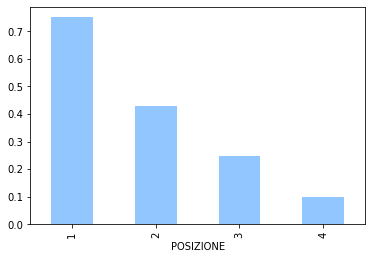

In [267]:
check.groupby("POSIZIONE")["probabilità di elezione"].mean().plot(kind="bar")

## animazione

In [268]:
diz_colori={"PD":"red","AZIONE-IV":"blue","M5S":"gold"}

In [277]:
risultati_finali["camera"]="Camera"
risultati_finali_senato["camera"]="Senato"

In [278]:
risultati_all=risultati_finali.append(risultati_finali_senato)

MovieWriter imagemagick unavailable; using Pillow instead.


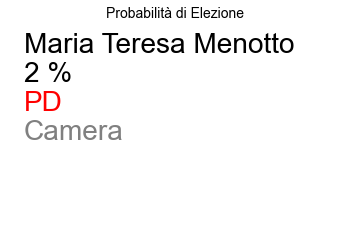

In [289]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')


fig = plt.figure()
ax = plt.axes(xlim=(-1,0), ylim=(-0.5,1))
ax.set_axis_off()
ax.set_title("Probabilità di Elezione",font="Arial",fontsize=14)
margine_sinistro=-0.95
#ax.text(x=margine_sinistro,y=0.5,s="probabilità di essere eletto",fontsize=5)

probabilita = ax.text(x=margine_sinistro,y=0.6, s="30%", fontsize=28,font="Arial")
candidato = ax.text(x=margine_sinistro,y=0.8, s="ELEZIONI 25 SETTEMBRE \n #totoparlamentarie", fontsize=28,font="Arial")
partito = ax.text(x=margine_sinistro,y=0.4, s="", fontsize=28,font="Arial")
camera_testo = ax.text(x=margine_sinistro,y=0.2, s="", fontsize=28,font="Arial")

### filtra quelliu della coalizione
risultati_all=risultati_all.loc[~risultati_all["candidato"].str.contains("COALIZIONE")].copy()
risultati_all.sort_values("probabilità di elezione",inplace=True,ascending=False)
risultati_all.reset_index(drop=True,inplace=True)



candidati = risultati_all["candidato"]
probabilities= risultati_all["probabilità di elezione"].apply(lambda x:str(int(x*100))+" %")
partiti=risultati_all["partito"]
colori=risultati_all["partito"].replace(diz_colori)
camere=risultati_all["camera"]
camere_colori=risultati_all["camera"].replace({"Camera":"grey","Senato":"black"})
def animate(i):
    cand=candidati[i]
    prob=probabilities[i]
    part=partiti[i]
    col=colori[i]
    cam=camere[i]
    col_camere=camere_colori[i]
    candidato.set_text(cand)
    probabilita.set_text(prob)
    partito.set_text(part)
    partito.set_color(col)
    camera_testo.set_text(cam)
    camera_testo.set_color(col_camere)
    
    return candidato,probabilita,partito,camera_testo

anim = FuncAnimation(fig, animate,frames=len(candidati), interval=250, blit=True)


anim.save('animazione_parlamentari.gif', writer='imagemagick')

##  import candidati 5 stelle

In [211]:
# import re

In [212]:
# candidati=pd.read_excel("D:\\Download_new\\LISTE-DI-CANDIDATI-CAMERA(1)(1).xlsx",sheet_name="Table 1")
# candidati2=pd.read_excel("D:\\Download_new\\LISTE-DI-CANDIDATI-CAMERA(1)(1).xlsx",sheet_name="Table 2")

camera

In [213]:
# df=pd.DataFrame()
# for g,collegio in zip(candidati.iloc[1:,2],candidati.iloc[1:,1]):
#     candidati_collegio=re.sub(r'\d',"", g.replace("\n","")).split(")  ")[1:]
#     candidati_collegio=[x for x in candidati_collegio if "  " not in x]
#     df=df.append(pd.DataFrame({"COLLEGIOPLURINOMINALE":collegio,"CANDIDATO":candidati_collegio,"POSIZIONE":range(1,len(candidati_collegio)+1)}))

# for g,collegio in zip(candidati2.iloc[1:,2],candidati2.iloc[1:,1]):
#     candidati_collegio=re.sub(r'\d',"", g.replace("\n","")).split(")  ")[1:]
#     candidati_collegio=[x for x in candidati_collegio if "  " not in x]
#     df=df.append(pd.DataFrame({"COLLEGIOPLURINOMINALE":collegio,"CANDIDATO":candidati_collegio,"POSIZIONE":range(1,len(candidati_collegio)+1)}))

# df["COLLEGIOPLURINOMINALE"]=df["COLLEGIOPLURINOMINALE"].apply(lambda x:x.split(" -")[0]+" - P"+x.split("- ")[1])

In [215]:
# df.to_excel("D:\\Download_new\\candidati_camera.xlsx")

senato

In [216]:
# candidati=pd.read_excel("D:\\Download_new\\LISTE-DI-CANDIDATI-SENATO(1).xlsx",sheet_name="Table 1")
# dr=pd.DataFrame()
# for g,collegio in zip(candidati.iloc[1:,2],candidati.iloc[1:,1]):
#     candidati_collegio=re.sub(r'\d',"", g.replace("\n","")).split(")  ")[1:]
#     candidati_collegio=[x.replace("   ","") for x in candidati_collegio]
#     dr=dr.append(pd.DataFrame({"COLLEGIOPLURINOMINALE":collegio,"CANDIDATO":candidati_collegio,"POSIZIONE":range(1,len(candidati_collegio)+1)}))
# dr["COLLEGIOPLURINOMINALE"]=dr["COLLEGIOPLURINOMINALE"].apply(lambda x:x.split(" -")[0]+" - P"+x.split("- ")[1])

In [217]:
# dr.to_excel("D:\\Download_new\\candidati_senato.xlsx")